# Data preprocessing

In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel('Online Retail.xlsx')


print(df.head())
print(df.info())
print(df['Country'].value_counts())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [3]:
df.duplicated().sum()

5268

In [4]:
df.drop_duplicates(inplace= True)
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
print(f"After removing missing CustomerID: {df.shape}")

After removing missing CustomerID: (401604, 8)


In [5]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"After removing invalid qty/price: {df.shape}")

After removing invalid qty/price: (392692, 8)


In [6]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
print(df.info())
print(f"Final cleaned dataset: {df.shape[0]} transactions from {df['CustomerID'].nunique()} customers")

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int32         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 28.5+ MB
None
Final cleaned dataset: 392692 transactions from 4338 customers


**RFM analysis — a common customer segmentation technique in marketing analytics.**

The Recency metric measures how long it’s been since a customer’s last purchase.

To compute Recency, we need a reference point in time — this is called the snapshot date (“today’s date” for our analysis).

In [12]:
# df['InvoiceDate'].max() → finds the most recent transaction date in the dataset.
# + pd.Timedelta(days=1) → adds one day to that, making it the day after the last.
# This ensures that even the most recent customer will have a non-zero recency value.

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Snapshot date for Recency: {snapshot_date}")

Snapshot date for Recency: 2011-12-10 12:50:00


In [18]:
# After defining the snapshot date, the next step is to aggregate data by customer to compute:
# Recency (R)	How recently the customer purchased	'snapshot_date - last_purchase_date'
# Frequency (F)	How often they purchase	'count of unique invoices per customer'
# Monetary (M)	How much money they spent 'sum of invoice amounts per customer'


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM Table:")
print(rfm.head())

RFM Table:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


In [19]:
print(f"Unique customers in RFM: {rfm['CustomerID'].nunique()}")

Unique customers in RFM: 4338


# Modeling

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']]


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)

# Convert back to DataFrame for readability
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])


print(rfm_scaled_df.head())

    Recency  Frequency  Monetary
0  2.334574  -0.425097  8.363010
1 -0.905340   0.354417  0.251699
2 -0.175360  -0.035340 -0.027988
3 -0.735345  -0.425097 -0.032406
4  2.174578  -0.425097 -0.190812


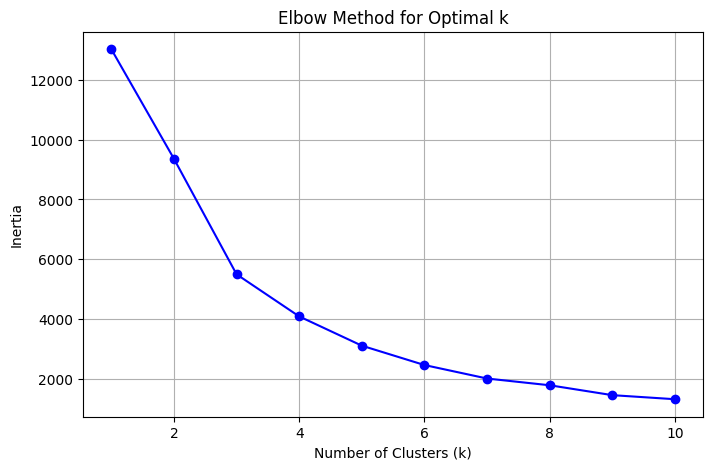

In [21]:
# Elbow method
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [22]:
# Train K-Means with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("Clustering done!")
print(rfm['Cluster'].value_counts())

Clustering done!
Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64


| Cluster | Count | Interpretation (Likely) |
|----------|--------|-------------------------|
| 0 | 3054 | Loyal Regulars – Low Recency, Medium Monetary |
| 1 | 1067 | At-Risk / Churned – High Recency, Low–Medium Spend |
| 2 | 204 | High-Value Customers – Low Recency, High Monetary |
| 3 | 13 | VIP / Whale Customers – Extremely High Spend |


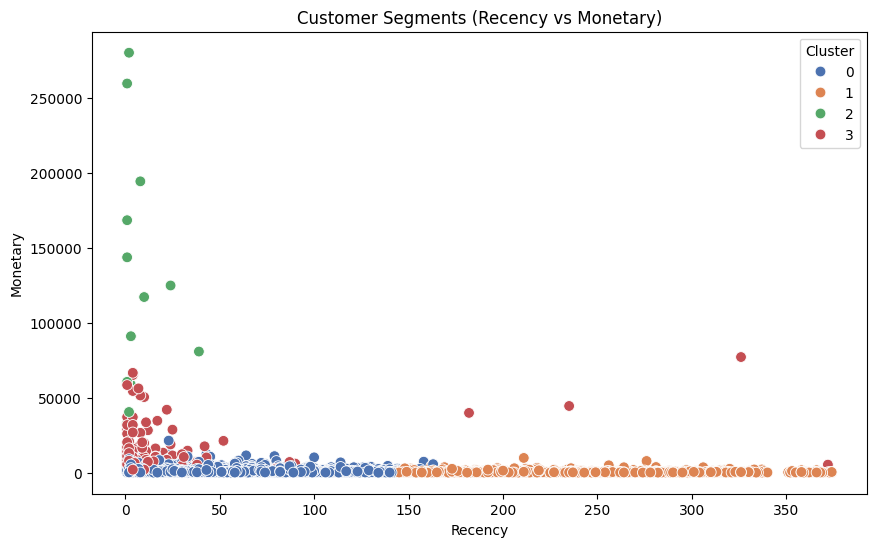

In [23]:
# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm, x='Recency', y='Monetary',
    hue='Cluster', palette='deep', s=60
)
plt.title('Customer Segments (Recency vs Monetary)')
plt.legend(title='Cluster')
plt.show()

| Observation | Meaning |
|--------------|----------|
| **Blue (0)** – Bottom-left dense cloud | Recent buyers, moderate spend → Core Customers |
| **Orange (1)** – Spread on the right | High Recency (haven’t bought in a while) → At-Risk |
| **Green (2)** – Scattered above 50k | Recent + High spend → High-Value Loyal |
| **Red (3)** – 13 points above 100k–250k | Ultra High-Value (outliers in spend) |


In [24]:
import joblib

# Save the trained model and scaler
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(rfm, 'rfm_data.pkl') 

print("Model and scaler saved as 'kmeans_model.pkl' and 'scaler.pkl'")

Model and scaler saved as 'kmeans_model.pkl' and 'scaler.pkl'
